In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pickle as pkl
import os, sys
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
sys.path.append('src')
from shared import TrajData, evaluate, do_evaluation

In [3]:
#data_dir = 'data/data-new'
#dat_suffix = ['Osak', 'Glas', 'Edin', 'Toro', 'Melb']
dat_name = ['Osaka', 'Glasgow', 'Edinburgh', 'Toronto']#, 'Melbourne']
C_SET = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]  # regularisation parameter
METRIC_MAX = True  # True: pick the best prediction, False: use the average of all predictions

In [4]:
#algo = ['rand', 'pop', 'linreg', 'logreg', 'rank', 'logpwr', 'tranDP', 'tranILP', 'combDP', 'combILP', \
#        'ssvm-greedy', 'ssvm-viterbi', 'ssvm-listViterbi', 'ssvm-ILP', 'memm']
#algo_name = ['Random', 'Popularity', 'POILocationPrediction', 'POIOccurrencePrediction', 'RankSVM', 'RankLogistic', \
#             'Markov', 'MarkovPath', 'Rank+Markov', 'Rank+MarkovPath', \
#             'SSVM-Greedy', 'SSVM-Viterbi', 'SSVM-ListViterbi', 'SSVM-ILP', 'MEMM']
#metric_name = ['F$_1$', 'pairs-F$_1$', '$\\tau$']

In [5]:
#algo = ['rand', 'pop10', 'rank10', 'ssvm-B10', 'ssvm-A10', 'ssvm-D10', 'ssvm-C10']
#algo = ['rand', 'pop', 'rank', 'ssvm-B', 'ssvm-A', 'ssvm-D', 'ssvm-C']
algo = ['rand10', 'pop10', 'rank10', 'markov10', 'ssvm-00', 'ssvm-01', 'ssvm-10', 'ssvm-11']
algo_name = ['\\textsc{Random}', '\\textsc{Popularity}', '\\textsc{PoiRank}', '\\textsc{Markov}', 
            '\\textsc{SP}', '\\textsc{SPpath}', '\\textsc{SR}', '\\textsc{SRpath}']
#            '\\textsc{SP}', '\\textsc{SPpath}', '\\textsc{SR} inf. w/o pairwise', '\\textsc{SRpath}']
metric_name = ['F$_1$', 'pairs-F$_1$', '$\\tau$']
styles = [':', '--', '-', '--', '-.', '-.', '-', '-']
markers = [None, None, None, 'o', 'o', 's', 'o', 's']
#ranges_short = [(0.5, 1.0), (0.5, 0.8), (0.5, 0.9)]
#ranges_long = [(0.5, 1.0), (0.5, 0.8), (0.5, 0.9)]
#index = [0, 1, 2, 3, 5]
#algo = [algo[ix] for ix in index]
#algo_name = [algo_name[ix] for ix in index]
#styles = [styles[ix] for ix in index]
#markers = [markers[ix] for ix in index]

In [6]:
skip_indices = [(4, 2), (6, 2)]  # (algo, dataset)

Histogram of the number of ground truths for queries.

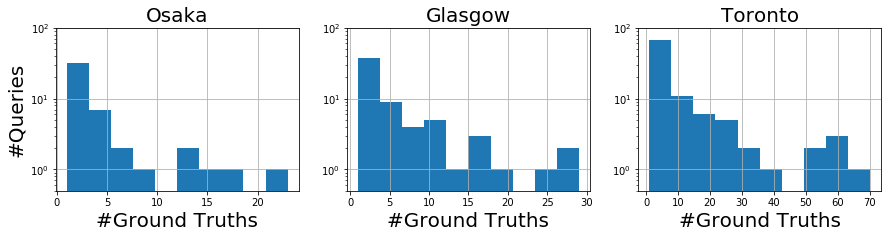

In [26]:
#%%script false
fig = plt.figure(figsize=[20, 3])
#for dat_ix in range(len(dat_name)):
#indices = [2, 1, 4, 0, 3]
indices = [0, 1, 3]
fsize = 20
for j in range(len(indices)):
    dat_ix = indices[j]
    dat_obj = TrajData(dat_ix)
    ax = plt.subplot(int('14' + str(j+1)))
    ax.set_xlabel('#Ground Truths')
    ax.xaxis.label.set_fontsize(fsize)
    if j == 0:
        ax.set_ylabel('#Queries')
        ax.yaxis.label.set_fontsize(fsize)
    ax.set_yscale('log')
    #ax.set_ylim([0.1, 1000])
    ax.set_ylim([0.5, 100])
    ax.set_title(dat_name[dat_ix])
    ax.title.set_fontsize(fsize)
    Y = [len(dat_obj.TRAJID_GROUP_DICT[q]) for q in dat_obj.TRAJID_GROUP_DICT]
    pd.Series(Y).hist(bins=10, ax=ax)
    fig.savefig('hist_query.svg')

Simple dataset stats.

In [8]:
dat_ix = 0
dat_obj = TrajData(dat_ix)

In [9]:
[dat_obj.traj_dict[tid] for tid in dat_obj.TRAJID_GROUP_DICT[(10,3)]]

[[10, 22, 7]]

In [10]:
ntrajs = np.sum([len(dat_obj.TRAJID_GROUP_DICT[q]) for q in dat_obj.TRAJID_GROUP_DICT.keys()])
print('#Traj:', ntrajs)

#Traj: 186


In [11]:
pois = {p for q in dat_obj.TRAJID_GROUP_DICT.keys() for tid in dat_obj.TRAJID_GROUP_DICT[q] \
        for p in dat_obj.traj_dict[tid]}
print('#POIs:', len(pois))

#POIs: 26


In [12]:
users = {dat_obj.traj_user.loc[tid, 'userID'] for q in dat_obj.TRAJID_GROUP_DICT.keys() \
         for tid in dat_obj.TRAJID_GROUP_DICT[q]}
print('#Users:', len(users))

#Users: 130


In [13]:
print('#Queries:', len(dat_obj.TRAJID_GROUP_DICT))

#Queries: 47


In [14]:
ntrajs_q = [len(dat_obj.TRAJID_GROUP_DICT[q]) for q in dat_obj.TRAJID_GROUP_DICT]

In [15]:
np.histogram(ntrajs_q, bins=[1, 2, 6, np.inf], density=False)

(array([17, 22,  8]), array([  1.,   2.,   6.,  inf]))

In [16]:
#Counter(ntrajs_q)

In [17]:
lengths = [len(dat_obj.traj_dict[tid]) for q in dat_obj.TRAJID_GROUP_DICT.keys() for tid in dat_obj.TRAJID_GROUP_DICT[q]]

In [18]:
#lentotal = np.sum([len(dat_obj.traj_dict[tid]) for q in dat_obj.TRAJID_GROUP_DICT.keys() \
#                   for tid in dat_obj.TRAJID_GROUP_DICT[q]])
lentotal = np.sum(lengths)
print('AvgLengh: %.1f' % (lentotal/ntrajs))

AvgLengh: 2.4


In [19]:
np.histogram(lengths, bins=[2, 5, np.inf], density=False)

(array([178,   8]), array([  2.,   5.,  inf]))

In [20]:
Counter(lengths)

Counter({2: 139, 3: 32, 4: 7, 5: 7, 6: 1})

Histogram of trajectory length.

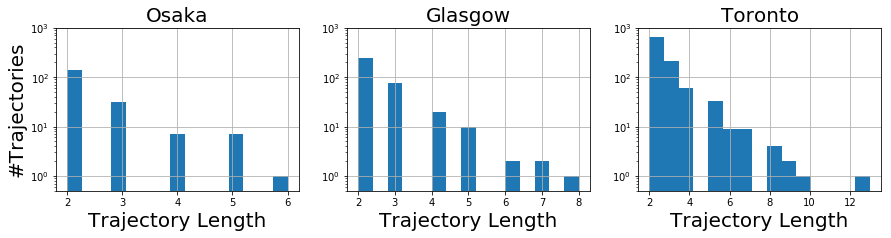

In [25]:
#%%script false
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
#plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':22})

fig = plt.figure(figsize=[20, 3])
indices = [0, 1, 3]
#nbins = [10, 20, 30]
fsize = 20
for j in range(len(indices)):
    dat_ix = indices[j]
    dat_obj = TrajData(dat_ix)
    ax = plt.subplot(int('14' + str(j+1)))
    ax.set_xlabel('Trajectory Length')
    ax.xaxis.label.set_fontsize(fsize)
    if j == 0: 
        ax.set_ylabel('#Trajectories')
        ax.yaxis.label.set_fontsize(fsize)
    ax.set_yscale('log')
    ax.set_ylim([0.5, 1000])
    ax.set_title(dat_name[dat_ix])
    ax.title.set_fontsize(fsize)
    Y = [len(dat_obj.traj_dict[tid]) for q in dat_obj.TRAJID_GROUP_DICT.keys() for tid in dat_obj.TRAJID_GROUP_DICT[q]]
    pd.Series(Y).hist(bins=15, ax=ax)
    
    fig.savefig('hist_length.svg')

Curves for hyper-parameter `C`.

In [ ]:
%%script false
plt.figure(figsize=[15, 5])
keys = sorted(recdict.keys())
X = np.arange(len(keys))
Y1 = [recdict[q]['C'] for q in keys]
Y2 = [recdict1[q]['C'] for q in keys]
Y3 = [recdict0[q]['C'] for q in keys]
#plt.plot(X, Y1, c='r', ls='--', marker='^', markeredgewidth=0, label='NEW-NOLOG')
plt.plot(X, Y2, c='g', ls='--', marker='v', markeredgewidth=0, label='NEW-LOG')
plt.plot(X, Y3, c='b', ls='--', marker='o', markeredgewidth=0, label='OLD-LOG')
plt.xticks(np.arange(len(keys)), [str(q) for q in keys], fontsize=10, rotation=50, horizontalalignment='right')
plt.xlim(-1, len(keys))
plt.ylim(0.001, 10000)
plt.plot([-1, len(keys)], [C_SET[0],  C_SET[0]],  c='b', ls='-')
plt.plot([-1, len(keys)], [C_SET[-1], C_SET[-1]], c='b', ls='-')
plt.yscale('log')
plt.xlabel('Query')
plt.ylabel('C')
plt.title('Values of hyper-parameter $C$')
plt.legend(loc='best')

Construct file names.

In [ ]:
def build_fnames(dat_obj, dat_ix):
    fnames = []
    for a in algo:
        fnames.append(os.path.join(dat_obj.data_dir, a + '-' + dat_obj.dat_suffix[dat_ix] + '.pkl'))
    return fnames        

In [ ]:
#fnames = build_fnames(dat_obj, dat_ix)
#fnames

Compute evaluation metrics.

In [ ]:
def calc_metrics(dat_obj, fnames, topk):
    assert(len(fnames) == len(algo))
    recdicts = []
    for f in fnames:
        recdicts.append(pkl.load(open(f, 'rb')))
    
    queries = set(recdicts[0].keys())
    #print(len(keys))
    for d in recdicts[1:]:
        queries = queries & set(d.keys())
        #print(len(d.keys()))
    print('#Records:', len(queries))
    queries = sorted(queries)
    
    metrics = np.zeros((len(algo), 3, len(queries)), dtype=np.float)
    #Cs = -1 * np.ones((len(algo), len(queries)), dtype=np.float)
    
    for i in range(len(recdicts)):
        #d = {q: {'PRED': recdicts[i][q]['PRED'][:topk], 'C': recdicts[i][q]['C']} for q in queries}
        d = {q: {'PRED': recdicts[i][q]['PRED'][:topk]} for q in queries}
        F1_list, pF1_list, Tau_list = do_evaluation(dat_obj, d, debug=False)
        assert(len(F1_list) == len(pF1_list) == len(Tau_list) == len(queries))
        metrics[i, 0, :] = F1_list
        metrics[i, 1, :] = pF1_list
        metrics[i, 2, :] = Tau_list
        
        #for k in range(len(queries)):
        #    q = queries[k]
        #    if 'C' in d[q]: Cs[i, k] = d[q]['C']
    #return metrics, queries, Cs
    return metrics

In [ ]:
#metrics, keys, Cs = calc_metrics(dat_obj, fnames)

In [ ]:
def calc_metrics_topk(dat_obj, fnames):
    assert(len(fnames) == len(algo))
    recdicts = []
    for f in fnames:
        recdicts.append(pkl.load(open(f, 'rb')))
    
    queries = set(recdicts[0].keys())
    #print(len(keys))
    for d in recdicts[1:]:
        queries = queries & set(d.keys())
        #print(len(d.keys()))
    print('#Records:', len(queries))
    queries = sorted(queries)
    
    TOPK = 10
    LONG = 5
    metrics_short = np.empty((len(algo), 3, TOPK), dtype=np.object)  # each item is a list of metrics
    metrics_long = np.empty((len(algo), 3, TOPK), dtype=np.object)
    
    for i in range(len(recdicts)):
        for k in range(TOPK):
            d_short = {q: {'PRED': recdicts[i][q]['PRED'][:k+1]} for q in queries if q[1] < LONG}
            d_long = {q: {'PRED': recdicts[i][q]['PRED'][:k+1]} for q in queries if q[1] >= LONG}
            F1_short, pF1_short, Tau_short = do_evaluation(dat_obj, d_short, use_max=METRIC_MAX, debug=False)
            F1_long, pF1_long, Tau_long = do_evaluation(dat_obj, d_long, use_max=METRIC_MAX, debug=False)
            assert(len(F1_short) == len(pF1_short) == len(Tau_short))
            assert(len(F1_long) == len(pF1_long) == len(Tau_long))
            assert(len(F1_short) + len(F1_long) == len(queries))
            metrics_short[i, 0, k] = F1_short
            metrics_short[i, 1, k] = pF1_short
            metrics_short[i, 2, k] = Tau_short
            metrics_long[i, 0, k] = F1_long
            metrics_long[i, 1, k] = pF1_long
            metrics_long[i, 2, k] = Tau_long
            
    return metrics_short, metrics_long

In [ ]:
#rankdict = pkl.load(open('data/data-new/rank10-Glas.pkl', 'rb'))

In [ ]:
#rankdict

In [ ]:
dat_ix = 3
dat_obj = TrajData(dat_ix)
fnames = build_fnames(dat_obj, dat_ix)
metrics_short, metrics_long = calc_metrics_topk(dat_obj, fnames)

In [ ]:
plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
metric_ix = 2  # [F1, pairs-F1, Tau]
TOPK = 10
fig = plt.figure(figsize=[12, 5])
X = np.arange(1, TOPK+1)
for i in range(len(algo)):
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    Y1 = [np.mean(metrics_short[i, metric_ix, k]) for k in range(TOPK)]
    Y2 = [np.mean(metrics_long[i, metric_ix, k]) for k in range(TOPK)]
    ax1.plot(X, Y1, ls=styles[i], marker=markers[i], markeredgewidth=0, label=algo_name[i]) #marker='^'
    ax2.plot(X, Y2, ls=styles[i], marker=markers[i], markeredgewidth=0, label=algo_name[i])
#    ax1.set_ylim(ranges[metric_ix])
#    ax2.set_ylim(ranges[metric_ix])
    ax1.set_xlabel('Top-K')
    ax2.set_xlabel('Top-K')
    ax1.set_ylabel(metric_name[metric_ix])
    ax2.set_ylabel(metric_name[metric_ix])
    ax1.set_title('Average ' + metric_name[metric_ix] + ' of short trajectories (length $<$ 5), ' + dat_name[dat_ix])
    ax2.set_title('Average ' + metric_name[metric_ix] + ' of long trajectories (length $\ge$ 5), ' + dat_name[dat_ix])
    ax1.legend(loc='lower right')
    ax2.legend(loc='lower right')
#fig.savefig(metric_name[metric_ix].replace('$', '').replace('\\', '') + '-np_' + dat_name[dat_ix] + '.svg')
fig.savefig(metric_name[metric_ix].replace('$', '').replace('\\', '') + '-' + dat_name[dat_ix] + '.svg')

Plot the values of metrics.

In [ ]:
%%script false
metric_ix = 0  # [F1, pairs-F1, Tau]

plt.figure(figsize=[15, 5])
X = np.arange(metrics.shape[2])
plt.plot(X, metrics[4, metric_ix, :], c='r', ls='--', marker='^', markeredgewidth=0, label='RankSVM')
plt.plot(X, metrics[12, metric_ix, :], c='g', ls='--', marker='v', markeredgewidth=0, label='SSVM-ListViterbi')
plt.xticks(np.arange(metrics.shape[2]), [str(q) for q in keys], fontsize=10, rotation=50, horizontalalignment='right')
plt.xlim(-1, metrics.shape[2])
plt.ylim(-0.1, 1.1)
plt.xlabel('Query')
plt.ylabel(metric_name[metric_ix])
plt.title('Values of evaluation metric ' + metric_name[metric_ix])
plt.legend(loc='best')

Plot values of hyper-parameters.

In [ ]:
%%script false
plt.figure(figsize=[15, 5])
X = np.arange(Cs.shape[1])
plt.plot(X, Cs[4, :], c='r', ls='--', marker='^', markeredgewidth=0, label='RankSVM')
plt.plot(X, Cs[12, :], c='g', ls='--', marker='v', markeredgewidth=0, label='SSVM-ListViterbi')
plt.xticks(np.arange(Cs.shape[1]), [str(q) for q in keys], fontsize=10, rotation=50, horizontalalignment='right')
plt.xlim(-1, Cs.shape[1])
plt.ylim(0.001, 10000)
plt.plot([-1, Cs.shape[1]], [C_SET[0],  C_SET[0]],  c='b', ls='-')
plt.plot([-1, Cs.shape[1]], [C_SET[-1], C_SET[-1]], c='b', ls='-')
plt.yscale('log')
plt.xlabel('Query')
plt.ylabel('C')
plt.title('Values of hyper-parameter $C$')
plt.legend(loc='best')

Generate LaTeX table for each dataset.

In [ ]:
def gen_latex_h(mean, stderr, title, label):
    assert(mean.shape == stderr.shape)
    assert(mean.shape == (len(algo), 3))
    
    max_1st = np.zeros(len(metric_name), dtype=np.int)
    max_2nd = np.zeros(len(metric_name), dtype=np.int)
    
    for j in range(mean.shape[1]):
        max_2nd[j], max_1st[j] = np.argsort(mean[:, j])[-2:]
    
    strs = []
    strs.append('\\begin{table*}[t]\n')
    strs.append('\\caption{' + title + '}\n')
    strs.append('\\label{' + label + '}\n')
    strs.append('\\centering\n')
    strs.append('\\begin{tabular}{l|' + (mean.shape[1])*'c' + '} \\hline\n')
    for j in range(mean.shape[1]):
        strs.append(' & ' + metric_name[j])
    strs.append(' \\\\ \\hline\n')
    for i in range(mean.shape[0]):
        strs.append(algo_name[i] + ' ')
        for j in range(mean.shape[1]):
            strs.append('& $')
            if i == max_1st[j]: strs.append('\\mathbf{')
            if i == max_2nd[j]: strs.append('\\mathit{')
            strs.append('%.3f' % mean[i, j] + '\\pm' + '%.3f' % stderr[i, j])
            if i in [max_1st[j], max_2nd[j]]: strs.append('}')
            strs.append('$ ')
        strs.append('\\\\\n')
    strs.append('\\hline\n')
    strs.append('\\end{tabular}\n')
    strs.append('\\end{table*}\n')
    return ''.join(strs)    

In [ ]:
%%script false
mean   = np.zeros((len(algo), 3), dtype=np.float)
stderr = np.zeros((len(algo), 3), dtype=np.float)
for i in range(len(algo)):
        mean[i, 0] = np.mean(metrics[i, 0, :]); stderr[i, 0] = np.std(metrics[i, 0, :]) / np.sqrt(metrics.shape[2])
        mean[i, 1] = np.mean(metrics[i, 1, :]); stderr[i, 1] = np.std(metrics[i, 1, :]) / np.sqrt(metrics.shape[2])
        mean[i, 2] = np.mean(metrics[i, 2, :]); stderr[i, 2] = np.std(metrics[i, 2, :]) / np.sqrt(metrics.shape[2])
strs = gen_latex_h(mean, stderr, 'Performance', 'tab:performance')
print(strs)

Generate LaTeX table for each evaluation metric.

In [ ]:
def calc_metric_mean(metrics_list, metric_ix):
    assert(len(metrics_list) == len(dat_name))
    assert(type(metric_ix) == int)
    assert(0 <= metric_ix < len(metric_name))
    mean   = np.zeros((len(algo), len(dat_name)), dtype=np.float)
    stderr = np.zeros((len(algo), len(dat_name)), dtype=np.float)
    for i in range(len(algo)):
        for j in range(len(dat_name)):
            mean[i, j]   = np.mean(metrics_list[j][i, metric_ix, :])
            stderr[i, j] = np.std(metrics_list[j][i, metric_ix, :]) / np.sqrt(metrics_list[j].shape[2])
    return mean, stderr   

In [ ]:
def calc_metric_diff(metrics_list, metric_ix, baseline_ix=2):
    assert(len(metrics_list) == len(dat_name))
    assert(type(metric_ix) == int)
    assert(0 <= metric_ix < len(metric_name))
    assert(type(baseline_ix) == int)
    assert(0 <= baseline_ix < len(algo))
    diffmetrics_list = []
    for dat_ix in range(len(metrics_list)):
        diffmetrics = metrics_list[dat_ix].copy()
        for i in range(diffmetrics.shape[0]):
            diffmetrics[i, 0, :] -= metrics_list[dat_ix][baseline_ix, 0, :]
            diffmetrics[i, 1, :] -= metrics_list[dat_ix][baseline_ix, 1, :]
            diffmetrics[i, 2, :] -= metrics_list[dat_ix][baseline_ix, 2, :]
        diffmetrics_list.append(diffmetrics)
    
    diffmean   = np.zeros((len(algo), len(dat_name)), dtype=np.float)
    diffstderr = np.zeros((len(algo), len(dat_name)), dtype=np.float)
    for i in range(len(algo)):
        for j in range(len(dat_name)):
            diffmean[i, j]   = np.mean(diffmetrics_list[j][i, metric_ix, :])
            diffstderr[i, j] = np.std(diffmetrics_list[j][i, metric_ix, :]) / np.sqrt(diffmetrics_list[j].shape[2])
    return diffmean, diffstderr

In [ ]:
def gen_latex_v(mean, stderr, title, label):
    assert(mean.shape == stderr.shape)
    assert(mean.shape == (len(algo), len(dat_name)))
    
    max_1st = np.zeros(len(dat_name), dtype=np.int)
    max_2nd = np.zeros(len(dat_name), dtype=np.int)
    
    for j in range(mean.shape[1]):
        max_2nd[j], max_1st[j] = np.argsort(mean[:, j])[-2:]
    
    strs = []
    strs.append('\\begin{table*}[t]\n')
    strs.append('\\caption{' + title + '}\n')
    #strs.append('\\label{' + label + '}\n')
    strs.append('\\centering\n')
    strs.append('\\begin{tabular}{l|' + (mean.shape[1])*'c' + '} \\hline\n')
    for j in range(mean.shape[1]):
        if j == 2: continue
        strs.append(' & ' + dat_name[j])
    strs.append(' \\\\ \\hline\n')
    for i in range(mean.shape[0]):
        strs.append(algo_name[i] + ' ')
        for j in range(mean.shape[1]):
            if j == 2: continue
            strs.append('& $')
            if i == max_1st[j]: strs.append('\\mathbf{')
            if i == max_2nd[j]: strs.append('\\mathit{')
            if (i, j) in skip_indices: strs.append('-')
            else: strs.append('%.3f' % mean[i, j] + '\\pm' + '%.3f' % stderr[i, j])
            if i in [max_1st[j], max_2nd[j]]: strs.append('}')
            strs.append('$ ')
        strs.append('\\\\\n')
    strs.append('\\hline\n')
    strs.append('\\end{tabular}\n')
    strs.append('\\end{table*}\n')
    return ''.join(strs)

In [ ]:
def gen_latex_m(mean_list, stderr_list, header_list, title, label):
    assert(len(mean_list) == len(stderr_list) == len(header_list))
    max_1st_list = []
    max_2nd_list = []
    for mean, stderr in zip(mean_list, stderr_list):
        assert(mean.shape == stderr.shape)
        assert(mean.shape == (len(algo), len(dat_name)))
        max_1st = np.zeros(len(dat_name), dtype=np.int)
        max_2nd = np.zeros(len(dat_name), dtype=np.int)
        for j in range(mean.shape[1]):
            max_2nd[j], max_1st[j] = np.argsort(mean[:, j])[-2:]
        max_1st_list.append(max_1st)
        max_2nd_list.append(max_2nd)
    
    strs = []
    strs.append('\\begin{table*}[t]\n')
    strs.append('\\caption{' + title + '}\n')
    strs.append('\\label{' + label + '}\n')
    strs.append('\\centering\n')
    strs.append('\\begin{tabular}{l|')
    for mean in mean_list:
        strs.append('|' + (mean.shape[1])*'c')
    strs.append('} \\hline\n')
    for header in header_list:
        strs.append('\\multicolumn{%d}{c}{%s} \\cline{2-%d}\n' % (len(dat_name),header,1+len(header_list)*len(dat_name)))
    for j in range(len(dat_name)):
        strs.append(' & ' + dat_name[j])
    strs.append(' \\\\ \\hline\n')
    for i in range(mean.shape[0]):
        strs.append(algo_name[i] + ' ')
        for j in range(mean.shape[1]):
            strs.append('& $')
            if i == max_1st[j]: strs.append('\\mathbf{')
            if i == max_2nd[j]: strs.append('\\mathit{')
            if (i, j) in skip_indices: strs.append('-')
            else: strs.append('%.3f' % mean[i, j] + '\\pm' + '%.3f' % stderr[i, j])
            if i in [max_1st[j], max_2nd[j]]: strs.append('}')
            strs.append('$ ')
        strs.append('\\\\\n')
    strs.append('\\hline\n')
    strs.append('\\end{tabular}\n')
    strs.append('\\end{table*}\n')
    return ''.join(strs)

In [ ]:
def gen_latex_t(mean, stderr, title, label):
    assert(mean.shape == stderr.shape)
    assert(mean.shape == (len(algo), len(dat_name)))
    
    max_1st = np.zeros(len(dat_name), dtype=np.int)
    max_2nd = np.zeros(len(dat_name), dtype=np.int)
    
    for j in range(mean.shape[1]):
        max_2nd[j], max_1st[j] = np.argsort(mean[:, j])[-2:]
    
    strs = []
    strs.append('\\begin{table*}[t]\n')
    strs.append('\\caption{' + title + '}\n')
    #strs.append('\\label{' + label + '}\n')
    strs.append('\\centering\n')
    #strs.append('\\begin{tabular}{l|' + (mean.shape[0])*'c' + '} \\hline\n')
    strs.append('\\begin{tabular}{l|cc|ccc|ccc} \\hline\n')
    for i in range(mean.shape[0]):
        strs.append(' & ' + algo_name[i])
    strs.append(' \\\\ \\hline\n')
    for j in range(mean.shape[1]):
        if j == 2: continue
        strs.append(dat_name[j] + ' ')
        for i in range(mean.shape[0]):
            strs.append('& $')
            if i == max_1st[j]: strs.append('\\mathbf{')
            if i == max_2nd[j]: strs.append('\\mathit{')
            if (i, j) in skip_indices: strs.append('-')
            else: strs.append('%.3f' % mean[i, j] + '\\pm' + '%.3f' % stderr[i, j])
            if i in [max_1st[j], max_2nd[j]]: strs.append('}')
            strs.append('$ ')
        strs.append('\\\\\n')
    strs.append('\\hline\n')
    strs.append('\\end{tabular}\n')
    strs.append('\\end{table*}\n')
    return ''.join(strs)

In [ ]:
#nb_stdout = sys.stdout  # save the device for notebook output
#sys.stdout = open('/dev/stdout', 'w')  # redirect the output of %run to terminal

In [ ]:
topk = 10  # [1, 3, 5, 10]
metrics_list = []
for dat_ix in range(len(dat_name)):
    dat_obj = TrajData(dat_ix)
    fnames = build_fnames(dat_obj, dat_ix)
    #metrics, keys, Cs = calc_metrics(dat_obj, fnames, topk)
    metrics = calc_metrics(dat_obj, fnames, topk)
    metrics_list.append(metrics)

In [ ]:
#sys.stdout = nb_stdout  # restore the output to notebook
#sys.stdout

Evaluation metrics and difference of evaluation metrics between baseline and others.

In [ ]:
#baseline_ix = 2
#baseline_algo = algo_name[baseline_ix]

In [ ]:
titles = ['F$_1$ score on points, top-%d' % topk, 'F$_1$ score on pairs, top-%d' % topk, \
          'Kendall\'s $\\tau$, top-%d' % topk]
labels = ['tab:f1', 'tab:pf1', 'tab:tau']

In [ ]:
#titles_diff = ['Difference of F$_1$ score on points from ' + baseline_algo, 
#               'Difference of F$_1$ score on pairs from ' + baseline_algo, 
#               'Difference of Kendall\'s $\\tau$ from ' + baseline_algo]
#labels_diff = ['tab:df1', 'tab:dpf1', 'tab:dtau']

In [ ]:
for metric_ix in range(len(metric_name)):
    mean, stderr = calc_metric_mean(metrics_list, metric_ix)
    print(gen_latex_t(mean, stderr, titles[metric_ix], labels[metric_ix]))
    #print(gen_latex_v(mean, stderr, titles[metric_ix], labels[metric_ix]))
    #diffmean, diffstderr = calc_metric_diff(metrics_list, metric_ix, baseline_ix=baseline_ix)
    #print(gen_latex_v(diffmean, diffstderr, titles_diff[metric_ix], labels_diff[metric_ix]))